In [7]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=22

train_cardiac_total=pd.read_csv("mimic_ca_vital_sign_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_ca_vital_sign_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_ca_baseline_total_v2.csv")

eicu_cardiac_total=pd.read_csv("eicu_total_"+str(T)+"hours.csv")

total_train=21540 #control+event
total_test=5384 #control+event
train_control=21160 #control


var=6
random=32
smote_ratio=1
near_ratio=1
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_nr=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
y_train_no_smote=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels
y_test_log=df_test_base['eventV3'].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

x_train_base_no_smote=minmax_scale.fit_transform(train_features)

#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

x_train_lstm_nr, y_train_nr = nr.fit_sample(train_cardiac_total, y_train_nr.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

print('timeline_no_smote:',x_train_lstm_no_smote.shape)
print('baseline_no_smote:',x_train_base_no_smote.shape)
print('label_no_smote:',y_train_no_smote.shape)


print('timeline_nr:',x_train_lstm_nr.shape)
print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


timeline: (21540, 132)
baseline: (21540, 70)
timeline: (42320, 22, 6)
baseline: (42320, 70)
label: (42320,)
timeline: (5384, 22, 6)
baseline: (5384, 70)
label: (5384, 1)
timeline_no_smote: (21540, 22, 6)
baseline_no_smote: (21540, 70)
label_no_smote: (21540, 1)
timeline_nr: (760, 22, 6)
label_nr: (760,)


In [8]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(42320, 22, 6)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 22, 8)             480       
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 22, 8)             32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 22, 8)             544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 8)             0         
_____________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 41s - loss: 0.5780 - accuracy: 0.7341 - f1_m: 0.5527 - precision_m: 0.7456 - val_loss: 0.6572 - val_accuracy: 0.5992 - val_f1_m: 0.7458 - val_precision_m: 1.0000
Epoch 3/3
 - 39s - loss: 0.5659 - accuracy: 0.7411 - f1_m: 0.5689 - precision_m: 0.7530 - val_loss: 0.7378 - val_accuracy: 0.5845 - val_f1_m: 0.7339 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 128.77 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.7131%
test accuracy = 84.101%
test error = 856 out of 5384 examples


In [9]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 1 0 0]


In [10]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
smote_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, smote_roc_auc = roc_curve_and_score(y_test, y_pred_smote)

smote_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
smote_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('smote_accuracy:%0.2f' %smote_accuracy)
print('smote_auc:  %0.2f' %smote_roc_auc)
print('smote_sensitivity : %0.2f' %smote_sensitivity)
print('smote_specificity : %0.2f' %smote_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4478  811]
 [  45   50]]
smote_accuracy:0.84
smote_auc:  0.74
smote_sensitivity : 0.53
smote_specificity : 0.85
ppv: 0.05807200929152149
npv: 0.9900508512049525


<Figure size 432x288 with 0 Axes>

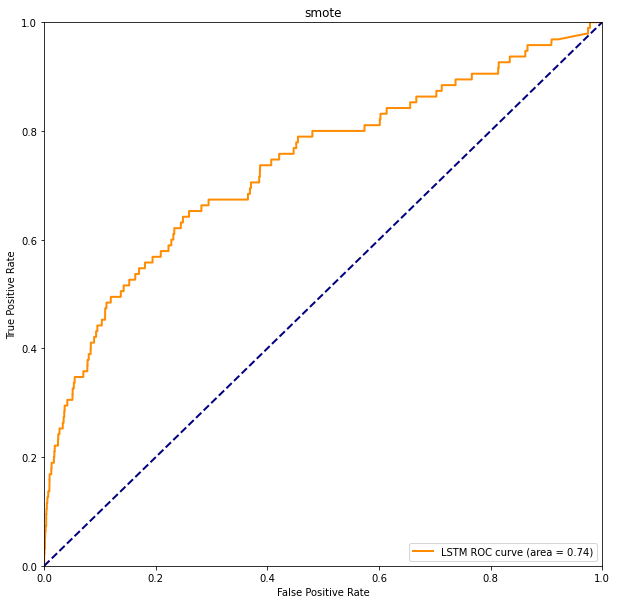

In [11]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [12]:
y_pred_smote

array([[0.21727785],
       [0.18319668],
       [0.24672838],
       ...,
       [0.77512246],
       [0.18522936],
       [0.4292634 ]], dtype=float32)

In [13]:
print(x_train_lstm_nr.shape)
print(y_train_nr.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_nr.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_nr = Sequential()

model_nr.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())

model_nr.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_nr.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_nr.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_nr.fit(x_train_lstm_nr, y_train_nr,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_nr.evaluate(x_train_lstm_nr, y_train_nr,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_nr.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(760, 22, 6)
(760,)
layers=[8, 8, 8, 1], train_examples=760, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_11 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 8)             0         
___________________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 1s - loss: 0.7558 - accuracy: 0.5707 - f1_m: 0.4636 - precision_m: 0.4342 - val_loss: 0.8100 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/3
 - 1s - loss: 0.7660 - accuracy: 0.5428 - f1_m: 0.3698 - precision_m: 0.3915 - val_loss: 0.8325 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
-----------------------------------------------------------------
Training was completed in 10.04 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.0%
test accuracy = 98.2355%
test error = 95 out of 5384 examples


In [14]:
y_pred_nr= model_nr.predict(x_test_lstm)

predict_test_nr=[]
for i in range(y_pred_nr.shape[0]): 
    if y_pred_nr[i]>0.5:
        predict_test_nr.append(1)
    else:
        predict_test_nr.append(0)
predict_test_nr = np.array(predict_test_nr)
print(predict_test_nr)

[0 0 0 ... 0 0 0]


In [15]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_nr,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_nr)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

nr_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, nr_roc_auc = roc_curve_and_score(y_test, y_pred_nr)
nr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
nr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('nr_accuracy: %0.2f' %nr_accuracy)
print('nr_auc: %0.2f' %nr_roc_auc)
print('nr_sensitivity: %0.2f' %nr_sensitivity)
print('nr_specificity: %0.2f' %nr_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5289    0]
 [  95    0]]
nr_accuracy: 0.98
nr_auc: 0.51
nr_sensitivity: 0.00
nr_specificity: 1.00
ppv: nan
npv: 0.9823551263001485


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

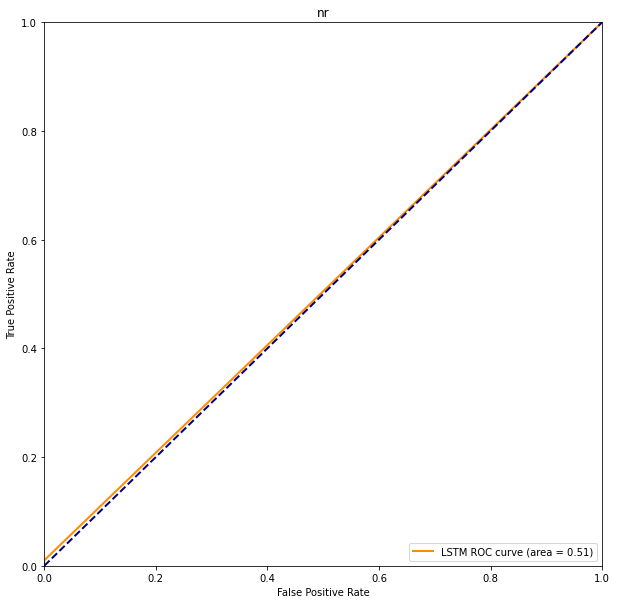

In [16]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_nr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('nr')
plt.legend(loc="lower right")

plt.show()

In [17]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_14 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_14 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 42s - loss: 0.6160 - accuracy: 0.6773 - f1_m: 0.6091 - precision_m: 0.7735 - val_loss: 0.5788 - val_accuracy: 0.7056 - val_f1_m: 0.3392 - val_precision_m: 0.5019
Epoch 3/3
 - 43s - loss: 0.5977 - accuracy: 0.6919 - f1_m: 0.6322 - precision_m: 0.7817 - val_loss: 0.5842 - val_accuracy: 0.7032 - val_f1_m: 0.4082 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 138.86 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 70.4809%
test accuracy = 71.5453%
test error = 1532 out of 5384 examples


In [18]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 1 0 1]


In [19]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3792 1497]
 [  35   60]]
sensitivity: 0.631578947368421
specificity: 0.7169597277368123
ppv: 0.038535645472061654
npv: 0.9908544551868305


In [20]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_16 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 41s - loss: 0.5986 - accuracy: 0.6981 - f1_m: 0.6615 - precision_m: 0.7531 - val_loss: 0.5820 - val_accuracy: 0.6923 - val_f1_m: 0.4212 - val_precision_m: 0.5013
Epoch 3/3
 - 40s - loss: 0.5973 - accuracy: 0.7007 - f1_m: 0.6666 - precision_m: 0.7509 - val_loss: 0.5728 - val_accuracy: 0.7089 - val_f1_m: 0.3602 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 131.95 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.9311%
test accuracy = 84.2125%
test error = 850 out of 5384 examples


In [21]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[0 0 0 ... 1 0 0]


In [22]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4484  805]
 [  45   50]]
specificity: 0.8477973151824542
sensitivity: 0.5263157894736842
ppv: 0.05847953216374269
npv: 0.9900640317950983


In [23]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_19 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_20 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 47s - loss: 0.6006 - accuracy: 0.7098 - f1_m: 0.6970 - precision_m: 0.7230 - val_loss: 0.6161 - val_accuracy: 0.6962 - val_f1_m: 0.4667 - val_precision_m: 0.5013
Epoch 3/3
 - 44s - loss: 0.5842 - accuracy: 0.7221 - f1_m: 0.7075 - precision_m: 0.7413 - val_loss: 0.5864 - val_accuracy: 0.7163 - val_f1_m: 0.4555 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 156.40 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.937%
test accuracy = 59.1753%
test error = 2198 out of 5384 examples


In [24]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 0 ... 1 0 1]


In [25]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[3117 2172]
 [  26   69]]
specificity: 0.5893363584798639
sensitivity: 0.7263157894736842
ppv: 0.030789825970548863
npv: 0.9917276487432389


In [26]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_22 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_23 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_23 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 44s - loss: 0.5907 - accuracy: 0.7084 - f1_m: 0.6905 - precision_m: 0.7331 - val_loss: 0.5572 - val_accuracy: 0.7075 - val_f1_m: 0.4413 - val_precision_m: 0.5010
Epoch 3/3
 - 50s - loss: 0.5690 - accuracy: 0.7225 - f1_m: 0.7078 - precision_m: 0.7444 - val_loss: 0.5306 - val_accuracy: 0.7468 - val_f1_m: 0.3938 - val_precision_m: 0.5014
-----------------------------------------------------------------
Training was completed in 154.83 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 74.4152%
test accuracy = 82.7823%
test error = 927 out of 5384 examples


In [27]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[0 0 0 ... 1 0 0]


In [28]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4410  879]
 [  48   47]]
specificity: 0.8338060124787294
sensitivity: 0.49473684210526314
ppv: 0.05075593952483801
npv: 0.9892328398384926


In [29]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_26 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_26 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 53s - loss: 0.5829 - accuracy: 0.7196 - f1_m: 0.7032 - precision_m: 0.7452 - val_loss: 0.5253 - val_accuracy: 0.7463 - val_f1_m: 0.4254 - val_precision_m: 0.5015
Epoch 3/3
 - 51s - loss: 0.5604 - accuracy: 0.7316 - f1_m: 0.7190 - precision_m: 0.7507 - val_loss: 0.6837 - val_accuracy: 0.5730 - val_f1_m: 0.4946 - val_precision_m: 0.5010
-----------------------------------------------------------------
Training was completed in 161.44 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 56.8466%
test accuracy = 16.9577%
test error = 4471 out of 5384 examples


In [30]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 1 1 ... 1 0 1]


In [31]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[ 823 4466]
 [   5   90]]
specificity: 0.1556059746643978
sensitivity: 0.9473684210526315
ppv: 0.019754170324846356
npv: 0.9939613526570048


In [32]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [33]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 1 0 1]


In [34]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

fpr, tpr, fold_roc_auc = roc_curve_and_score(y_test, y_pred)

specificity_5_fold = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity_5_fold = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('5_fold_accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('5_fold_auc : %0.2f' %fold_roc_auc)  #accuracy
print('5_fold_sensitivity: %0.2f' %sensitivity_5_fold)
print('5_fold_specificity: %0.2f' %specificity_5_fold)

print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[3622 1667]
 [  29   66]]
5_fold_accuracy : 0.68
5_fold_auc : 0.75
5_fold_sensitivity: 0.69
5_fold_specificity: 0.68
ppv: 0.038084246970571264
npv: 0.6848175458498771


<Figure size 432x288 with 0 Axes>

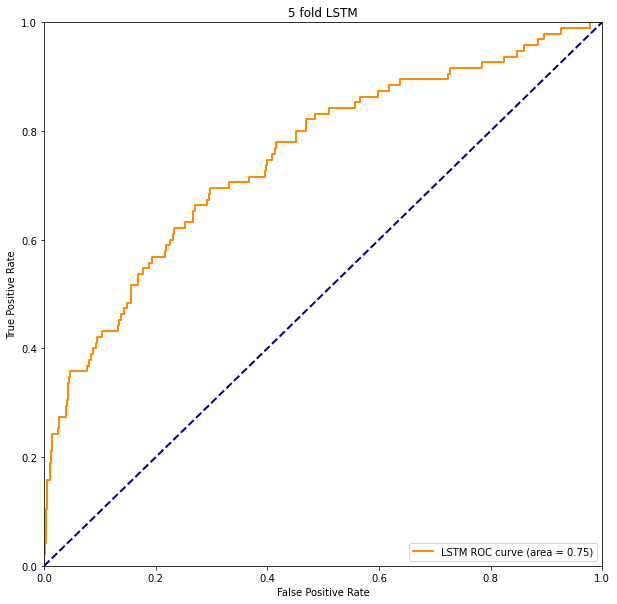

In [35]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [36]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.68
AUC : 0.75
Sensitivity : 0.95
Specificity :0.16
63.66731359720643


In [37]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import model_selection

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest = forest.fit(x_train_base, y_train)

prob_predict_y_validation1 = forest.predict_proba(x_train_base)#给出带有概率值的结果，每个点所有label的概率和为1
prob_predict_y_validation = forest.predict_proba(x_test_base)#给出带有概率值的结果，每个点所有label的概率和为1


y_score = prob_predict_y_validation[:, 1]
# 預測
predict_train_rf = prob_predict_y_validation1[:, 1]

test_y_predicted = forest.predict(x_test_base)

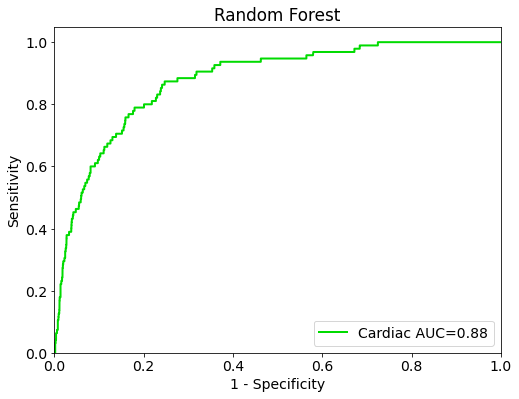

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Random Forest')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [39]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(total_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

Accuracy  = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])   

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Accuracy : %0.2f' %Accuracy)  #Accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)



Confusion Matrix : 
 [[4967  322]
 [  46   49]]
Accuracy : 0.93
AUC : 0.88
Sensitivity : 0.52
Specificity :0.94


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(x_train_base, y_train)

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [41]:
predict_train_logistic_result = logreg.predict_proba(x_train_base)

predict_train_logistic = predict_train_logistic_result[:, 1]

logreg_test_y_predicted = logreg.predict_proba(x_test_base)

log_y_score = logreg_test_y_predicted[:, 1]

predict_test=[]
for i in range(log_y_score.shape[0]): 
    if log_y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_log,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.799777
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4231,1058
1,20,75


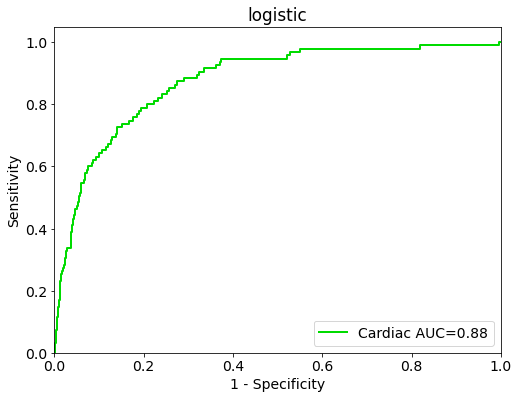

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('logistic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [43]:
print(predict_train_logistic)
print(predict_train_lstm)

stacking=np.append(predict_train_logistic, predict_train_lstm)
x_train_stacking=np.array(stacking).reshape(x_train_lstm.shape[0],2, order='F') #轉維

from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm_stacking = svm.SVC(kernel='linear',probability=True)
svm_stacking.fit(x_train_stacking,y_train)

print(x_train_stacking.shape)
print(y_train.shape)

print(log_y_score.shape)#logistic test 機率
print(y_pred.shape)#lstm test 機率 
print(y_score.shape)#Rf test 機率

stacking_test=np.append(y_pred, log_y_score)
x_test_stacking=np.array(stacking_test).reshape(total_test,2, order='F') #轉維


[0.14063802 0.03412005 0.47621695 ... 0.64044788 0.85612376 0.2473725 ]
[0.34718624 0.36613137 0.5353979  ... 0.5949121  0.7902783  0.6733516 ]
(42320, 2)
(42320,)
(5384,)
(5384,)
(5384,)


In [44]:
predict=svm_stacking.predict(x_test_stacking)
predict_pro_stacking=svm_stacking.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_test, predict)
precision  = metrics.precision_score(y_test, predict)

print(accuracy)
print(precision)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_stacking=predict_pro_stacking[:,1:2]

#################92個test ca 輸出#####################
#test=pd.DataFrame(predict[4689:])
#test.to_csv('24hour_ca.csv', index=False)
####################################### predict_pro_stacking

0.8268945022288261
0.07769929364278506


In [45]:
predict_test_stacking=[]
for i in range(predict_pro_stacking.shape[0]): 
    if predict_pro_stacking[i]>0.5:
        predict_test_stacking.append(1)
    else:
        predict_test_stacking.append(0)
predict_test_stacking = np.array(predict_test_stacking)


In [46]:
#pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  

y_test_1D=np.array(y_test).reshape(total_test)

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_stacking)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

fpr, tpr, stacking_svm_roc_auc = roc_curve_and_score(y_test, predict_pro_stacking)

stacking_svm_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1]) 


print('stacking_svm_Accuracy: %0.2f' %stacking_svm_accuracy)
print('stacking_svm_auc: %0.2f' %stacking_svm_roc_auc)
print('stacking_svm_sensitivity: %0.2f' %stacking_svm_sensitivity)
print('stacking_svm_specificity: %0.2f' %stacking_svm_specificity)

print('ppv:',ppv)
print('npv:',npv)
flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro_stacking[i]>0.5:
            total_predict=total_predict+predict_pro_stacking[i]
            flag=flag+1
#print(flag)  #score

#print(y_test_1D)

Confusion Matrix : 
 [[4417  872]
 [  19   76]]
stacking_svm_Accuracy: 0.83
stacking_svm_auc: 0.89
stacking_svm_sensitivity: 0.80
stacking_svm_specificity: 0.84
ppv: 0.08016877637130802
npv: 0.8351295140858386


<Figure size 432x288 with 0 Axes>

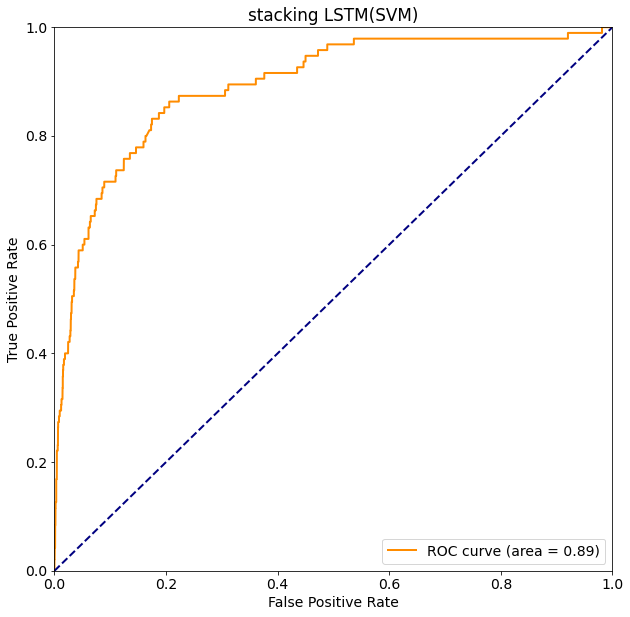

In [47]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, predict_pro_stacking) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM(SVM)')
plt.legend(loc="lower right")

plt.show()

In [48]:
print('Accuracy : %0.2f' %accuracy)  #Accuracy
print('precision : %0.2f' %precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

Accuracy : 0.83
precision : 0.08
AUC : 0.89
Sensitivity : 0.79
Specificity :0.80
[75.63627123]


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn import model_selection

gbm = xgb.XGBRegressor()

xgb_params = {
'learning_rate': [0.1,0.2,0.5],
'n_estimators': [30,50,100],
'max_depth': [5,10,20],
 'alpha': [0.4,0.6],
 }

xg_reg = model_selection.GridSearchCV(gbm, xgb_params, cv=5)
xg_reg.fit(x_train_stacking,y_train)

y_pred_xgb = xg_reg.predict(x_test_stacking)


In [50]:
predict_test_xgb=[]
for i in range(y_pred_xgb.shape[0]): 
    if y_pred_xgb[i]>0.5:
        predict_test_xgb.append(1)
    else:
        predict_test_xgb.append(0)
predict_test_xgb = np.array(predict_test_xgb)

pd.crosstab(y_test_1D,predict_test_xgb,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_xgb)

fpr, tpr, stacking_xg_roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

stacking_xg_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_xg_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_xg_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


print('stacking_xg_accuracy : %0.2f' % stacking_xg_accuracy )
print('stacking_xg_auc : %0.2f' % stacking_xg_roc_auc )
print('stacking_xg_Sensitivity : %0.2f' % stacking_xg_sensitivity )
print('stacking_xg_Specificity :%0.2f' % stacking_xg_specificity)

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
print('accuracy :%0.2f' % accuracy)


Confusion Matrix : 
 [[4404  885]
 [  19   76]]
stacking_xg_accuracy : 0.83
stacking_xg_auc : 0.89
stacking_xg_Sensitivity : 0.80
stacking_xg_Specificity :0.83
accuracy :0.83


In [51]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

forest_stacking = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
#'n_estimators': [5],
#'max_depth': [5]
 }

forest_stacking = model_selection.GridSearchCV(forest_stacking, rf_params, cv=5)
forest_fit=forest_stacking.fit(x_train_stacking,y_train)

prob_predict_y_validation_stacking = forest_stacking.predict_proba(x_test_stacking)#给出带有概率值的结果，每个点所有label的概率和为1
y_score_stacking = prob_predict_y_validation_stacking[:, 1]


In [52]:
predict_test=[]
for i in range(y_score_stacking.shape[0]): 
    if y_score_stacking[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
stacking_rf_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_rf_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

fpr,tpr,stacking_rf_roc_auc = roc_curve_and_score(y_test, y_score_stacking) ###計算真正率和假正率

stacking_rf_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('stacking_rf_accuracy :%0.2f' % stacking_rf_accuracy)
print('stacking_rf_roc_auc : %0.2f' % stacking_rf_roc_auc)  #AUC
print('stacking_rf_sensitivity : %0.2f' % stacking_rf_sensitivity )
print('stacking_rf_Specificity :%0.2f' % stacking_rf_specificity)

print(forest_stacking.best_params_)
print(forest_stacking.best_score_)

Confusion Matrix : 
 [[4439  850]
 [  20   75]]
stacking_rf_accuracy :0.84
stacking_rf_roc_auc : 0.89
stacking_rf_sensitivity : 0.79
stacking_rf_Specificity :0.84
{'max_depth': 7, 'n_estimators': 25}
0.84336011342155


In [53]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train_stacking, y_train)

KNeighborsClassifier(n_neighbors=2)

In [54]:
nei_test_y_predicted = neigh.predict(x_test_stacking)
predict_test=[]
for i in range(nei_test_y_predicted.shape[0]): 
    if nei_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix
fpr, tpr, stacking_nei_roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)

cm1 = confusion_matrix(y_test_1D,predict_test)

stacking_nei_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
stacking_nei_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
stacking_nei_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))

print('stacking_nei_accuracy : %0.2f' % stacking_nei_accuracy )
print('stacking_nei_roc_auc : %0.2f' % stacking_nei_roc_auc )

print('stacking_nei_Sensitivity : %0.2f' % stacking_nei_sensitivity )
print('stacking_nei_Specificity :%0.2f' % stacking_nei_specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])


stacking_nei_accuracy : 0.87
stacking_nei_roc_auc : 0.78
stacking_nei_Sensitivity : 0.68
stacking_nei_Specificity :0.88


predict,0,1
label,,
0,4640,649
1,30,65


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg_stacking = LogisticRegression()
logreg_stacking.fit(x_train_stacking, y_train)
#log_test_y_predicted = logreg.fit(x_train_stacking, y_train).decision_function(X_test)

LogisticRegression()

In [56]:
logreg_test_y_predicted_pro = logreg_stacking.predict_proba(x_test_stacking)

log_score = logreg_test_y_predicted_pro[:, 1]

predict_test_lr=[]
for i in range(log_score.shape[0]): 
    if log_score[i]>0.5:
        predict_test_lr.append(1)
    else:
        predict_test_lr.append(0)
predict_test_lr = np.array(predict_test_lr)

#print(predict_test)

fpr, tpr, stacking_lr_roc_auc = roc_curve_and_score(y_test, log_score)

cm1 = confusion_matrix(y_test_1D,predict_test_lr)

stacking_lr_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
stacking_lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))

print('stacking_lr_accuracy : %0.2f' % stacking_lr_accuracy )
print('stacking_lr_roc_auc : %0.2f' % stacking_lr_roc_auc )

print('stacking_lr_sensitivity : %0.2f' % stacking_lr_sensitivity )
print('stacking_lr_specificity :%0.2f' % stacking_lr_specificity)


pd.crosstab(y_test_1D,predict_test_lr,rownames=['label'],colnames=['predict'])

stacking_lr_accuracy : 0.83
stacking_lr_roc_auc : 0.89
stacking_lr_sensitivity : 0.80
stacking_lr_specificity :0.83


predict,0,1
label,,
0,4401,888
1,19,76


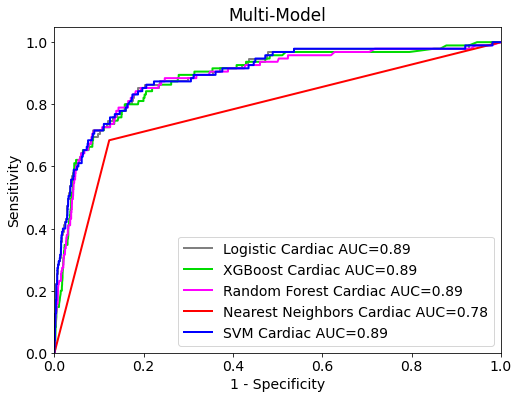

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

#plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_score)
plt.plot(fpr, tpr, color='gray', lw=2,
         label='Logistic Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='XGBoost Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score_stacking)
plt.plot(fpr, tpr, color='#ff00ff', lw=2,
         label='Random Forest Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)
plt.plot(fpr, tpr, color='red', lw=2,
         label='Nearest Neighbors Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, predict_pro_stacking)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SVM Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Multi-Model')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [58]:
y_score_stacking

array([0.45614791, 0.46551794, 0.07903515, ..., 0.91502334, 0.99290378,
       0.89720764])

In [59]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)


for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

5384


In [60]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

svm_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, svm_roc_auc = roc_curve_and_score(y_test, y_predict_combine)

svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('svm_accuracy_cxr : %0.2f' % svm_accuracy)
print('svm_auc_cxr : %0.2f' % svm_roc_auc )
print('svm_Sensitivity_cxr : %0.2f' % svm_sensitivity )
print('svm_Specificity_cxr :%0.2f' % svm_specificity)


Confusion Matrix : 
 [[4438  851]
 [  15   80]]
svm_accuracy_cxr : 0.84
svm_auc_cxr : 0.89
svm_Sensitivity_cxr : 0.84
svm_Specificity_cxr :0.84


<Figure size 432x288 with 0 Axes>

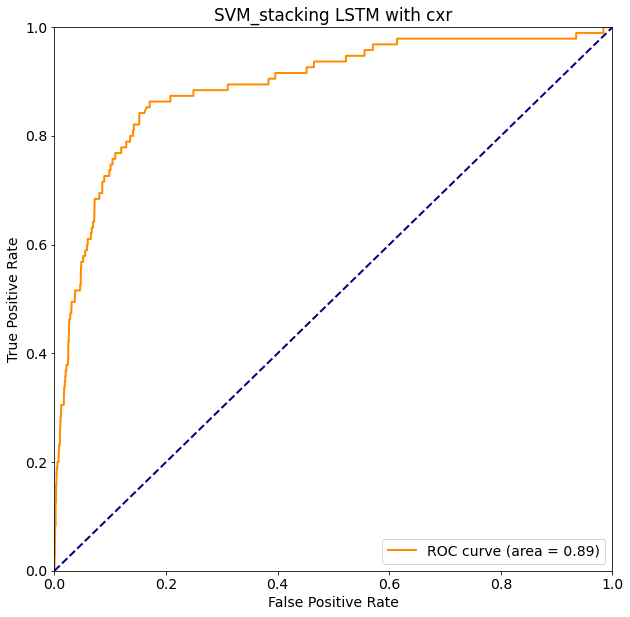

In [61]:
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [62]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_lr=[]

for idx, i in enumerate(log_score):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_lr.append(log_score[idx])
    else:
        y_predict_combine_lr.append((log_score[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_lr=np.array(y_predict_combine_lr)
print(y_predict_combine_lr.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [63]:
predict_test_combine=[]
for i in range(y_predict_combine_lr.shape[0]): 
    if y_predict_combine_lr[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

lr_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, lr_roc_auc = roc_curve_and_score(y_test, y_predict_combine_lr)

lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('lr_accuracy_cxr : %0.2f' % lr_accuracy)
print('lr_auc_cxr : %0.2f' % lr_roc_auc )
print('lr_Sensitivity_cxr : %0.2f' % lr_sensitivity )
print('lr_Specificity_cxr :%0.2f' % lr_specificity)

Confusion Matrix : 
 [[4431  858]
 [  15   80]]
lr_accuracy_cxr : 0.84
lr_auc_cxr : 0.89
lr_Sensitivity_cxr : 0.84
lr_Specificity_cxr :0.84


<Figure size 432x288 with 0 Axes>

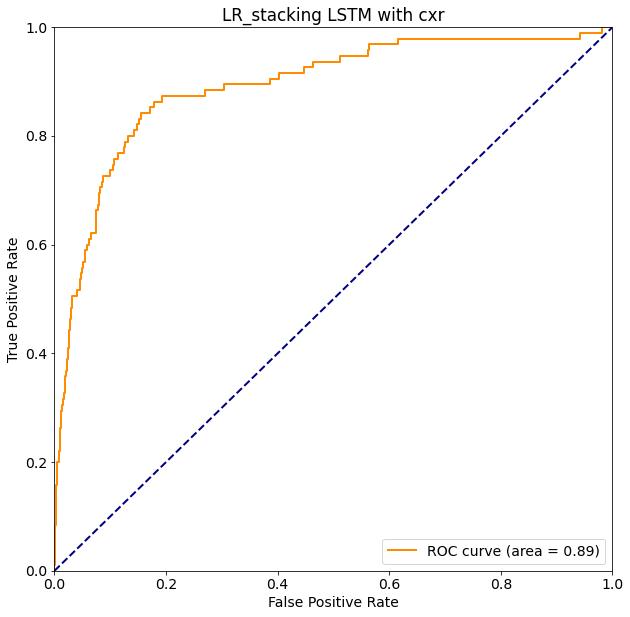

In [64]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine_lr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [65]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_xg=[]

for idx, i in enumerate(y_pred_xgb):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_xg.append(y_pred_xgb[idx])
    else:
        y_predict_combine_xg.append((y_pred_xgb[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_xg=np.array(y_predict_combine_xg)
print(y_predict_combine_xg.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [66]:
predict_test_combine=[]
for i in range(y_predict_combine_xg.shape[0]): 
    if y_predict_combine_xg[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

xg_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, xg_roc_auc = roc_curve_and_score(y_test, y_predict_combine_xg)

xg_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
xg_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('xg_accuracy_cxr : %0.2f' % xg_accuracy)
print('xg_auc_cxr : %0.2f' % xg_roc_auc )
print('xg_Sensitivity_cxr : %0.2f' % xg_sensitivity )
print('xg_Specificity_cxr :%0.2f' % xg_specificity)

Confusion Matrix : 
 [[4422  867]
 [  15   80]]
xg_accuracy_cxr : 0.84
xg_auc_cxr : 0.89
xg_Sensitivity_cxr : 0.84
xg_Specificity_cxr :0.84


In [67]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_rf=[]

for idx, i in enumerate(y_score_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_rf.append(y_score_stacking[idx])
    else:
        y_predict_combine_rf.append((y_score_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_rf=np.array(y_predict_combine_rf)
print(y_predict_combine_rf.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [68]:
predict_test_combine=[]
for i in range(y_predict_combine_rf.shape[0]): 
    if y_predict_combine_rf[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

rf_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, rf_roc_auc = roc_curve_and_score(y_test, y_predict_combine_rf)

rf_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
rf_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('rf_accuracy_cxr : %0.2f' % rf_accuracy)
print('rf_auc_cxr : %0.2f' % rf_roc_auc )
print('rf_Sensitivity_cxr : %0.2f' % rf_sensitivity )
print('rf_Specificity_cxr :%0.2f' % rf_specificity)

Confusion Matrix : 
 [[4439  850]
 [  16   79]]
rf_accuracy_cxr : 0.84
rf_auc_cxr : 0.89
rf_Sensitivity_cxr : 0.83
rf_Specificity_cxr :0.84


0.11907054517733197


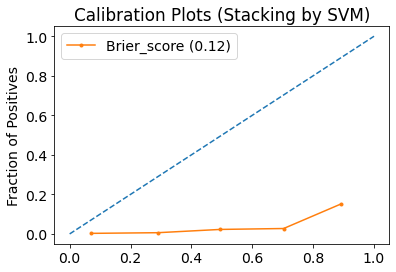

In [69]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, predict_pro_stacking)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, predict_pro_stacking)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by SVM)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

0.11916388696274936


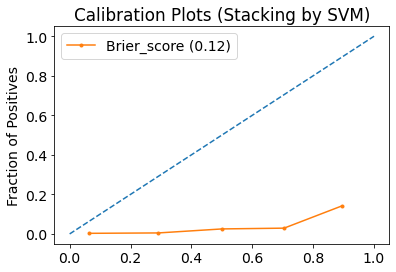

In [70]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, log_score)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, log_score)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by SVM)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

In [71]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

y_validation=df_eicu['user']

x_lstm_validation=eicu_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation=np.array(x_lstm_validation).reshape(10665,T,var) #轉三維  total 

print(x_lstm_validation.shape)
print(y_validation.shape)

(10665, 22, 6)
(10665,)


-----------------------------------------------------------------
test accuracy = 70.1078%
test error = 3188 out of 10665 examples


<Figure size 432x288 with 0 Axes>

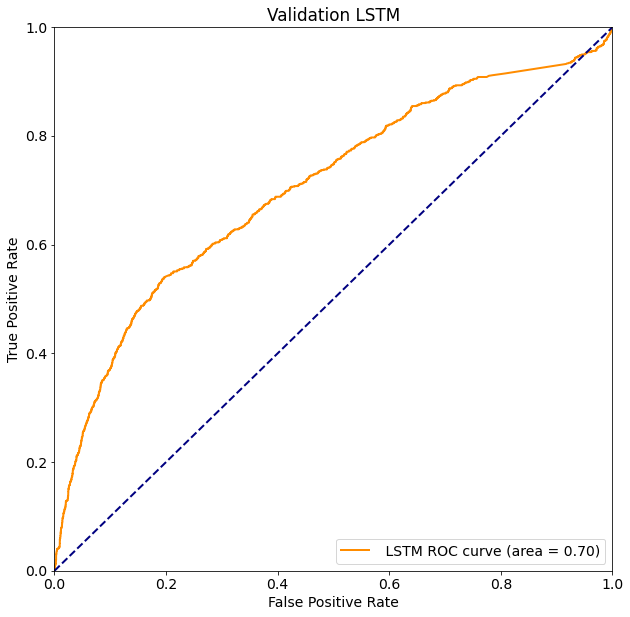

In [72]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_1) * 10665)} out of {10665} examples')

validation_pred1= model_1.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 65.1477%
test error = 3717 out of 10665 examples


<Figure size 432x288 with 0 Axes>

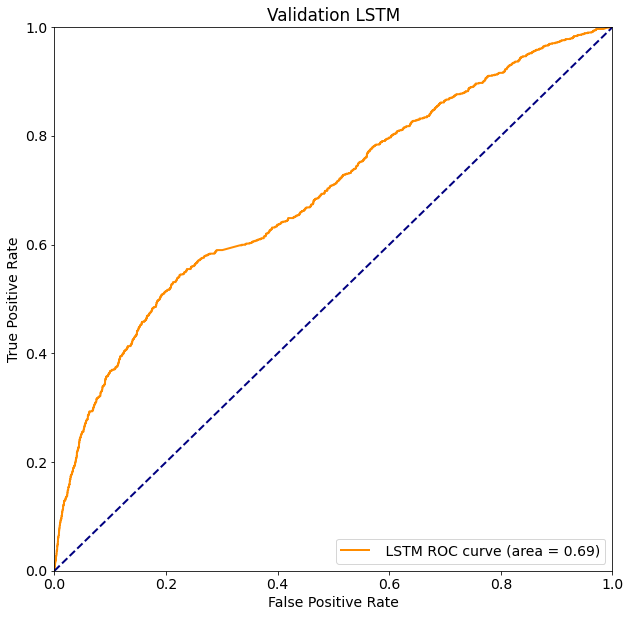

In [73]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_2) * 10665)} out of {10665} examples')

validation_pred2= model_2.predict(x_lstm_validation)


# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 40.4688%
test error = 6349 out of 10665 examples


<Figure size 432x288 with 0 Axes>

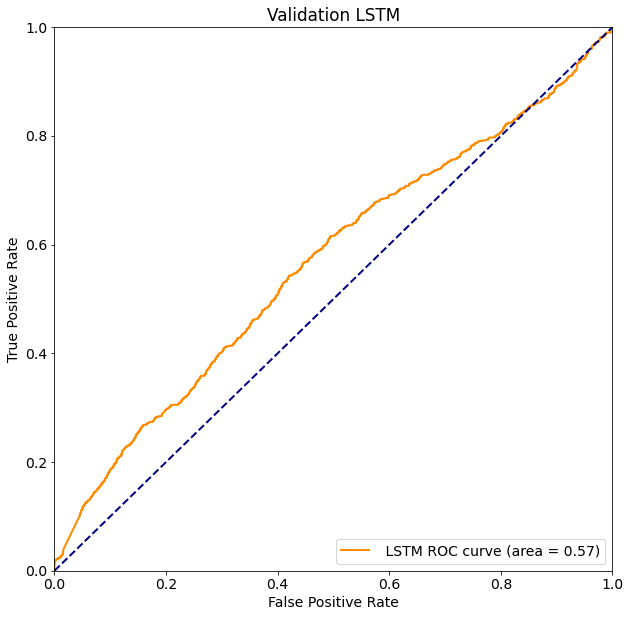

In [74]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_3) * 10665)} out of {10665} examples')

validation_pred3= model_3.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 66.5729%
test error = 3565 out of 10665 examples


<Figure size 432x288 with 0 Axes>

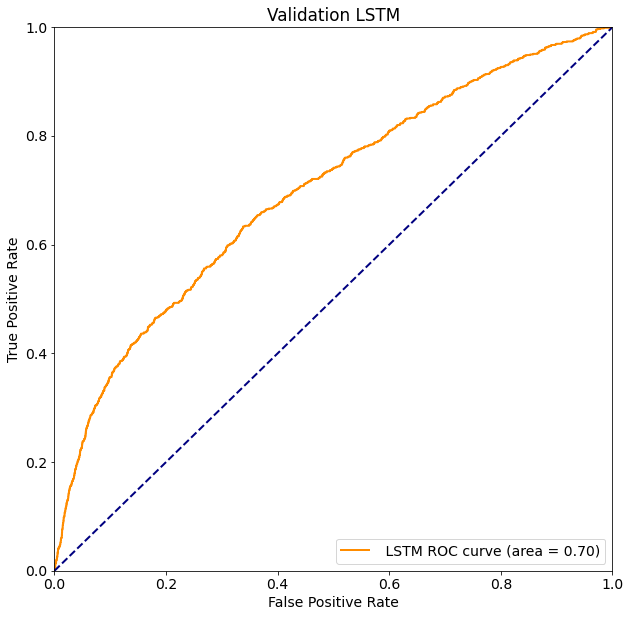

In [75]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_4) * 10665)} out of {10665} examples')

validation_pred4= model_4.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 16.5401%
test error = 8901 out of 10665 examples


<Figure size 432x288 with 0 Axes>

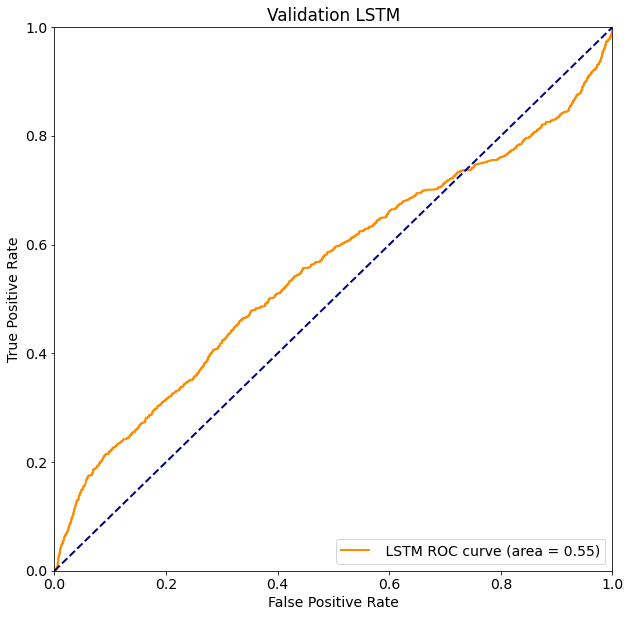

In [76]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * 10665)} out of {10665} examples')

validation_pred5= model_5.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [77]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

validation_pred_old=np.array(pred_temp).reshape(10665,5, order='F') #轉維

validation_pred_old= np.mean(validation_pred_old, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

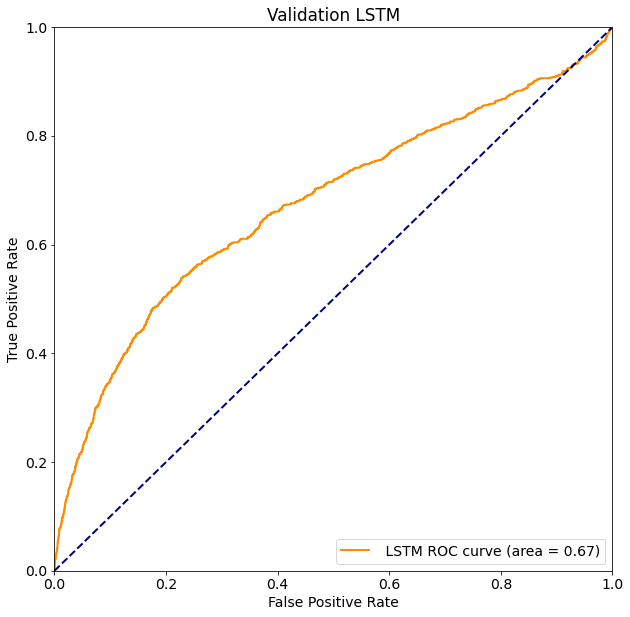

In [78]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [79]:
y_validation_1D=np.array(y_validation).reshape(10665)

predict_test=[]
for i in range(validation_pred_old.shape[0]): 
    if validation_pred_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[4552 5196]
 [ 241  676]]


In [80]:
df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline 

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation_old=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation_old=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_validation_old=minmax_scale.fit_transform(x_validation_old)

#predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
#y_score_validation_old = predict_validation[:, 1] #RF

predict_validation_old = logreg.predict_proba(x_validation_old)
y_score_validation_old = predict_validation_old[:, 1]

predict_test=[]
for i in range(y_score_validation_old.shape[0]): 
    if y_score_validation_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation_old).reshape(10665)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[8118 1630]
 [ 478  439]]


In [81]:
stacking_validation_test=np.append(validation_pred_old, y_score_validation_old)
x_validation_stacking=np.array(stacking_validation_test).reshape(10665,2, order='F') #轉維

predict=svm_stacking.predict(x_validation_stacking)
predict_pro_old=svm_stacking.predict_proba(x_validation_stacking)

accuracy = metrics.accuracy_score(y_validation_old, predict)
precision  = metrics.precision_score(y_validation_old, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_old=predict_pro_old[:,1:2]

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

valid_svm_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, valid_svm_roc_auc = roc_curve_and_score(y_validation_old, predict_pro_old)

valid_svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
valid_svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  


print('valid_svm_accuracy: %0.2f' %valid_svm_accuracy)
print('valid_svm_roc_auc: %0.2f' %valid_svm_roc_auc)
print('valid_svm_sensitivity: %0.2f' %valid_svm_sensitivity)
print('valid_svm_specificity: %0.2f' %valid_svm_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[7784 1964]
 [ 416  501]]
valid_svm_accuracy: 0.78
valid_svm_roc_auc: 0.74
valid_svm_sensitivity: 0.55
valid_svm_specificity: 0.80
ppv: 0.20324543610547668
npv: 0.9492682926829268


<Figure size 432x288 with 0 Axes>

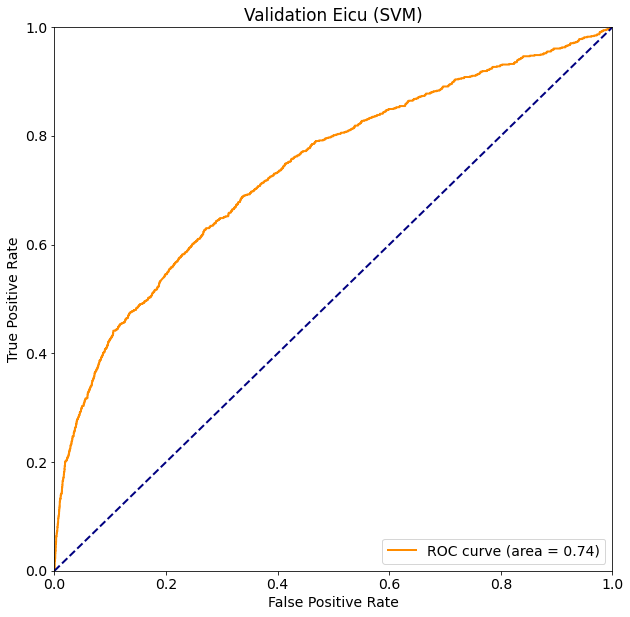

In [82]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation_old, predict_pro_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Eicu (SVM)')
plt.legend(loc="lower right")

plt.show()

predict_pro_old =pd.DataFrame(predict_pro_old)
#predict_pro_old.to_csv('predict.csv', index=False)

In [83]:
predict_lr=logreg_stacking.predict(x_validation_stacking)
predict_pro_old_lr=logreg_stacking.predict_proba(x_validation_stacking)

accuracy = metrics.accuracy_score(y_validation_old, predict_lr)
precision  = metrics.precision_score(y_validation_old, predict_lr)

pd.crosstab(y_test_1D,predict_lr,rownames=['label'],colnames=['predict'])
predict_pro_old_lr=predict_pro_old_lr[:,1:2]

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_lr)
print('Confusion Matrix : \n', cm1)

#####from confusion matrix calculate


fpr, tpr, valid_lr_roc_auc = roc_curve_and_score(y_validation_old, predict_pro_old_lr)

valid_lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
valid_lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

valid_lr_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

print('valid_lr_accuracy: %0.2f' %valid_lr_accuracy)
print('valid_lr_roc_auc: %0.2f' %valid_lr_roc_auc)
print('valid_lr_sensitivity: %0.2f' %valid_lr_sensitivity)
print('valid_lr_specificity: %0.2f' %valid_lr_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[7944 1804]
 [ 435  482]]
valid_lr_accuracy: 0.79
valid_lr_roc_auc: 0.73
valid_lr_sensitivity: 0.53
valid_lr_specificity: 0.81
ppv: 0.21084864391951005
npv: 0.9480844969566774


<Figure size 432x288 with 0 Axes>

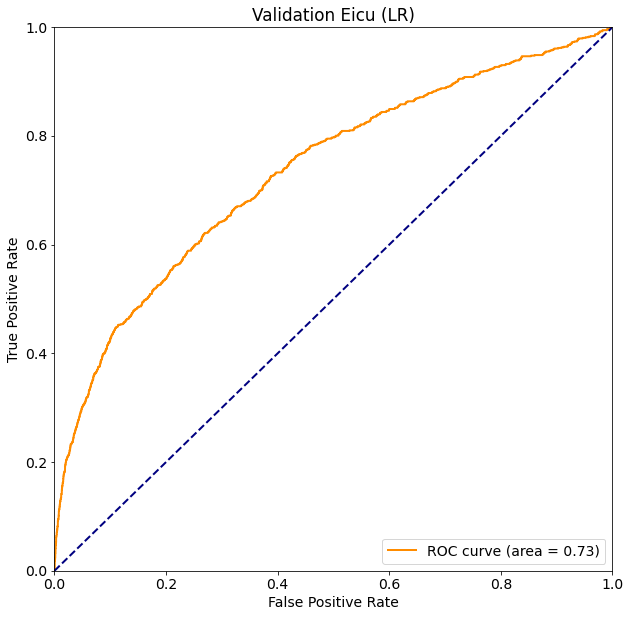

In [84]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation_old, predict_pro_old_lr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Eicu (LR)')
plt.legend(loc="lower right")

plt.show()

predict_pro_old_lr =pd.DataFrame(predict_pro_old_lr)
#predict_pro_old.to_csv('predict.csv', index=False)

In [85]:
print('smote_accuracy:%0.2f' %smote_accuracy)
print('smote_auc:  %0.2f' %smote_roc_auc)
print('smote_sensitivity : %0.2f' %smote_sensitivity)
print('smote_specificity : %0.2f\n' %smote_specificity)

print('nr_accuracy: %0.2f' %nr_accuracy)
print('nr_auc: %0.2f' %nr_roc_auc)
print('nr_sensitivity: %0.2f' %nr_sensitivity)
print('nr_specificity: %0.2f\n' %nr_specificity)

print('5_fold_accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('5_fold_auc : %0.2f' %fold_roc_auc)  #accuracy
print('5_fold_sensitivity: %0.2f' %sensitivity_5_fold)
print('5_fold_specificity: %0.2f\n' %specificity_5_fold)

print('stacking_svm_Accuracy: %0.2f' %stacking_svm_accuracy)
print('stacking_svm_auc: %0.2f' %stacking_svm_roc_auc)
print('stacking_svm_sensitivity: %0.2f' %stacking_svm_sensitivity)
print('stacking_svm_specificity: %0.2f' %stacking_svm_specificity)
print('svm_accuracy_cxr : %0.2f' % svm_accuracy)
print('svm_auc_cxr : %0.2f' % svm_roc_auc )
print('svm_Sensitivity_cxr : %0.2f' % svm_sensitivity )
print('svm_Specificity_cxr :%0.2f\n' % svm_specificity)

print('stacking_lr_Accuracy: %0.2f' %stacking_lr_accuracy)
print('stacking_lr_auc: %0.2f' %stacking_lr_roc_auc)
print('stacking_lr_sensitivity: %0.2f' %stacking_lr_sensitivity)
print('stacking_lr_specificity: %0.2f' %stacking_lr_specificity)
print('lr_accuracy_cxr : %0.2f' % lr_accuracy)
print('lr_auc_cxr : %0.2f' % lr_roc_auc )
print('lr_Sensitivity_cxr : %0.2f' % lr_sensitivity )
print('lr_Specificity_cxr :%0.2f\n' % lr_specificity)

print('stacking_xg_Accuracy: %0.2f' %stacking_xg_accuracy)
print('stacking_xg_auc: %0.2f' %stacking_xg_roc_auc)
print('stacking_xg_sensitivity: %0.2f' %stacking_xg_sensitivity)
print('stacking_xg_specificity: %0.2f' %stacking_xg_specificity)
print('xg_accuracy_cxr : %0.2f' % xg_accuracy)
print('xg_auc_cxr : %0.2f' % xg_roc_auc )
print('xg_Sensitivity_cxr : %0.2f' % xg_sensitivity )
print('xg_Specificity_cxr :%0.2f\n' % xg_specificity)

print('stacking_rf_Accuracy: %0.2f' %stacking_rf_accuracy)
print('stacking_rf_auc: %0.2f' %stacking_rf_roc_auc)
print('stacking_rf_sensitivity: %0.2f' %stacking_rf_sensitivity)
print('stacking_rf_specificity: %0.2f' %stacking_rf_specificity)
print('rf_accuracy_cxr : %0.2f' % rf_accuracy)
print('rf_auc_cxr : %0.2f' % rf_roc_auc )
print('rf_Sensitivity_cxr : %0.2f' % rf_sensitivity )
print('rf_Specificity_cxr :%0.2f\n' % rf_specificity)

print('valid_svm_accuracy: %0.2f' %valid_svm_accuracy)
print('valid_svm_roc_auc: %0.2f' %valid_svm_roc_auc)
print('valid_svm_sensitivity: %0.2f' %valid_svm_sensitivity)
print('valid_svm_specificity: %0.2f\n' %valid_svm_specificity)

print('valid_lr_accuracy: %0.2f' %valid_lr_accuracy)
print('valid_lr_roc_auc: %0.2f' %valid_lr_roc_auc)
print('valid_lr_sensitivity: %0.2f' %valid_lr_sensitivity)
print('valid_lr_specificity: %0.2f' %valid_lr_specificity)




smote_accuracy:0.84
smote_auc:  0.74
smote_sensitivity : 0.53
smote_specificity : 0.85

nr_accuracy: 0.98
nr_auc: 0.51
nr_sensitivity: 0.00
nr_specificity: 1.00

5_fold_accuracy : 0.68
5_fold_auc : 0.75
5_fold_sensitivity: 0.69
5_fold_specificity: 0.68

stacking_svm_Accuracy: 0.83
stacking_svm_auc: 0.89
stacking_svm_sensitivity: 0.80
stacking_svm_specificity: 0.84
svm_accuracy_cxr : 0.84
svm_auc_cxr : 0.89
svm_Sensitivity_cxr : 0.84
svm_Specificity_cxr :0.84

stacking_lr_Accuracy: 0.83
stacking_lr_auc: 0.89
stacking_lr_sensitivity: 0.80
stacking_lr_specificity: 0.83
lr_accuracy_cxr : 0.84
lr_auc_cxr : 0.89
lr_Sensitivity_cxr : 0.84
lr_Specificity_cxr :0.84

stacking_xg_Accuracy: 0.83
stacking_xg_auc: 0.89
stacking_xg_sensitivity: 0.80
stacking_xg_specificity: 0.83
xg_accuracy_cxr : 0.84
xg_auc_cxr : 0.89
xg_Sensitivity_cxr : 0.84
xg_Specificity_cxr :0.84

stacking_rf_Accuracy: 0.84
stacking_rf_auc: 0.89
stacking_rf_sensitivity: 0.79
stacking_rf_specificity: 0.84
rf_accuracy_cxr : 0.84


In [86]:
#test_avg=pd.DataFrame(x_test_stacking)
#test_avg.to_csv('test_avg.csv', index=False)

In [87]:
#predict_pro_stacking_pri=pd.DataFrame(predict_pro_stacking)
#predict_pro_stacking_pri.to_csv('predict_pro_stacking_pri.csv', index=False)
